In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES, CircleFace
from GCTree_preparation import *
import warnings
import math
warnings.filterwarnings("ignore")

path_to_storage = "/media/hieunguyen/HNSD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/GSHD_HN01/outdir/sc_bulk_BCR_data_analysis_v0.1"

PROJECT = "220701_etc_biopsies"
path_to_main_output = f"{outdir}/tree_analysis/{PROJECT}"
path_to_01_output = os.path.join(path_to_main_output, "01_output")
os.system(f"mkdir -p {path_to_01_output}")
os.system(f"mkdir -p {os.path.join(path_to_01_output, 'input_circos_public_clones')}")

output_type = "mouse_based_output"

path_to_trees = os.path.join(path_to_storage, PROJECT, "GCtrees/v0.2", output_type)

all_tree_folder = [item for item in pathlib.Path(path_to_trees).glob("*") if 
                   os.path.isfile(f"{str(item)}/02_dnapars/gctree.out.inference.1.nk") == True]

all_nk_files = [item for item in pathlib.Path(path_to_trees).glob("*/*/*gctree.out.inference.1.nk")]  
print(f"Number of trees: {len(all_tree_folder)}")   

path_to_metadata = "/media/hieunguyen/HNSD01/src/sc_bulk_BCR_data_analysis/preprocessing/220701_etc_biopsies/metadata.csv"
mid_metadata = pd.read_csv(path_to_metadata, sep =";")

##### Re run the summary analysis of all trees and rendering tree figures
# rerun = True
rerun = False

path_to_04_output = os.path.join(outdir, "VDJ_output", "04_output")
thres = 0.85

clonedf = pd.read_csv(os.path.join(path_to_04_output, "full_clonedf_with_mutation_rate.csv"), index_col= [0])
clonedf = clonedf[clonedf['num_mutation'] != "region_not_covered-skip"]
clonedf = clonedf[clonedf['dataset.name'] == "220701_etc_biopsies"]


/home/hieunguyen/miniconda3/envs/ete3_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of trees: 0


In [2]:
if (os.path.isfile(f"{path_to_01_output}/tree_summarydf.csv") == False) or (rerun == True):
    saveTreeobj = dict()
    # loop through all trees
    maindf = pd.DataFrame()
    # for treedir in tqdm(all_tree_folder[0:1]):
    for treedir in tqdm(all_tree_folder):
        cloneid = treedir.name
        treedir = str(treedir)

        mouseID = cloneid.split("_")[0]
        V_gene = cloneid.split("_")[1]
        J_gene = cloneid.split("_")[2]
        CDR3_len = cloneid.split("_")[3]

        nk_path = f"{treedir}/02_dnapars/gctree.out.inference.1.nk"
        ab_dict_path = os.path.join(treedir, "01_deduplicate", f"{cloneid}.abundance.csv")
        path_to_orig_fasta= f"{treedir}/01_deduplicate/{cloneid}.fasta"
        input_idmaps = f"{treedir}/01_deduplicate/{cloneid}.id_map_seq.csv"
    
        treeobj = GCtree(
            nk_path = nk_path,
            ab_dict_path = ab_dict_path,
            origin_fasta = path_to_orig_fasta,
            idmap_seq = input_idmaps
        )
        
        saveTreeobj[cloneid] = treeobj
        seqdf_orig = treeobj.seqdf
        seqs = treeobj.seqs
        num_nodes = len(treeobj.nodes)
        num_leaves = len(treeobj.leaves)
        num_internal_nodes = len(treeobj.internal_nodes)
        num_passthrough_nodes = len(treeobj.passthrough_nodes)
        num_split_nodes = len(treeobj.split_nodes)
        num_observed_nodes = len(treeobj.observed_nodes)
        num_inferred_nodes = len(treeobj.inferred_nodes)
        count_single_node = treeobj.count_single_node
        count_mix_node = treeobj.count_mix_node
        all_MIDs = seqdf_orig["MID"].unique()
        all_groups = [mid_metadata[mid_metadata["Unnamed: 0"] == item]["population"].unique()[0] for item in all_MIDs]
        tmpdf = pd.DataFrame(
            {
                "cloneid": cloneid,
                "mouseID": mouseID,
                "V_gene": V_gene,
                "J_gene": J_gene,
                "CDR3_len": CDR3_len,
                "num_nodes": num_nodes,
                "num_leaves": num_leaves,
                "num_internal_nodes": num_internal_nodes,
                "num_passthrough_nodes": num_passthrough_nodes,
                "num_split_nodes": num_split_nodes,
                "num_observed_nodes": num_observed_nodes,
                "num_inferred_nodes": num_inferred_nodes,
                "num_MID": len(all_MIDs),
                "available_population": ",".join(all_groups),
                "num_seq_fasta": len(seqs),
                "num_single_node": count_single_node,
                "num_mix_node": count_mix_node
            },
            index=[0],
        )
        maindf = pd.concat([maindf, tmpdf], axis = 0)
    maindf = maindf.sort_values(by = "num_MID", ascending = False)
    maindf["check_QC_tree"] = maindf["cloneid"].apply(lambda x: "CDR3 region not covered" if "region_not_cover" in saveTreeobj[x].seqdf.ID.values[0] else "pass")
    maindf.to_csv(f"{path_to_01_output}/tree_summarydf.csv", index = False)
    with open(f"{path_to_01_output}/saveTreeobj.pkl", "wb") as f:
        pickle.dump(saveTreeobj, f)
else:
    maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.csv")
    # Reload the dictionary from the pickle file
    with open(f"{path_to_01_output}/saveTreeobj.pkl", "rb") as f:
        saveTreeobj = pickle.load(f)

color_path = "./hex_color.csv"
mid_metadata.columns = ['MID', 'mouse', 'age', 'day', 'population', 'label',
       'Unnamed: 6', 'Unnamed: 7', 'hex color']

In [3]:
if (os.path.isfile(f"{path_to_01_output}/finished_tree_rendering.csv") == False) or (rerun == True):
    for cloneid in tqdm(saveTreeobj.keys()):
        mouseid = cloneid.split("_")[0]
        path_to_save_tree_svg = os.path.join(path_to_01_output, mouseid)
        os.system(f"mkdir -p {path_to_save_tree_svg}")

        treeobj = saveTreeobj[cloneid] 
        avai_mids = treeobj.seqdf["MID"].unique()
        mid_color_pal = pd.read_csv(color_path, index_col = [0]).to_dict()["hex color"]

        ts = treeobj.generate_tree_style(color_path = color_path)
        # treeobj.tree.render("%%inline", tree_style=ts) 

        for input_mid in avai_mids:
            if input_mid == "GL":
                input_mid_col = "gray"
            else:
                input_mid_col = mid_color_pal[input_mid]
            ts.legend.add_face(CircleFace(10, input_mid_col), column = 0)
            ts.legend.add_face(TextFace(input_mid), column = 0)

        _ = treeobj.tree.render(f"{path_to_save_tree_svg}/{cloneid}.svg", tree_style=ts) 
    pd.DataFrame(data = ["finished_tree_rendering"]).to_csv(f"{path_to_01_output}/finished_tree_rendering.csv", index = False, header = False)

In [4]:
mixed_node_df = maindf[
    (maindf["num_mix_node"] > 0) & 
    (maindf["check_QC_tree"] == "pass") & 
    (maindf["available_population"].str.contains("biopsy"))].sort_values(by = "num_mix_node", ascending = False)
mixed_node_df

,cloneid,mouseID,V_gene,J_gene,CDR3_len,num_nodes,num_leaves,num_internal_nodes,num_passthrough_nodes,num_split_nodes,num_observed_nodes,num_inferred_nodes,num_MID,available_population,num_seq_fasta,num_single_node,num_mix_node,check_QC_tree
71,m30_IGHV1-82-01_IGHJ2-01_30_1.aln,m30,IGHV1-82-01,IGHJ2-01,30,83,46,36,13,23,72,11,5,"biopsy,Ly6c+YFP+,Ly6c+YFP-,Ly6c-YFP+,Ly6c-YFP-",86,69,3,pass
400,m31_IGHV1-26-01_IGHJ1-03_48_4.aln,m31,IGHV1-26-01,IGHJ1-03,48,50,31,18,5,13,43,7,4,"biopsy,Ly6c+YFP+,Ly6c+YFP-,Ly6c-YFP-",59,40,3,pass
42,m30_IGHV9-3-01_IGHJ3-01_45_1.aln,m30,IGHV9-3-01,IGHJ3-01,45,31,23,7,0,7,30,1,5,"biopsy,Ly6c+YFP+,Ly6c+YFP-,Ly6c-YFP+,Ly6c-YFP-",39,28,2,pass
33,m30_IGHV4-1-01_IGHJ1-03_48_2.aln,m30,IGHV4-1-01,IGHJ1-03,48,26,17,8,1,7,22,4,5,"biopsy,Ly6c+YFP+,Ly6c+YFP-,Ly6c-YFP+,Ly6c-YFP-",29,20,2,pass
31,m12_IGHV1-55-01_IGHJ4-01_48_1.aln,m12,IGHV1-55-01,IGHJ4-01,48,130,73,56,16,40,106,24,5,"biopsy,Ly6c+YFP+,Ly6c+YFP-,Ly6c-YFP+,Ly6c-YFP-",129,104,2,pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,m30_IGHV10-1-01_IGHJ2-01_30_1.aln,m30,IGHV10-1-01,IGHJ2-01,30,251,142,108,33,75,219,32,5,"biopsy,Ly6c+YFP+,Ly6c+YFP-,Ly6c-YFP+,Ly6c-YFP-",252,218,1,pass
10,m12_IGHV9-3-01_IGHJ3-01_48_2.aln,m12,IGHV9-3-01,IGHJ3-01,48,13,7,5,2,3,12,1,5,"biopsy,Ly6c+YFP+,Ly6c+YFP-,Ly6c-YFP+,Ly6c-YFP-",18,11,1,pass
7,m53_IGHV1-39-01_IGHJ1-03_63_1.aln,m53,IGHV1-39-01,IGHJ1-03,63,67,36,30,13,17,56,11,5,"biopsy,Ly6c+YFP+,Ly6c+YFP-,Ly6c-YFP+,Ly6c-YFP-",72,55,1,pass
3829,m39_IGHV1-66-01_IGHJ3-01_39_1.aln,m39,IGHV1-66-01,IGHJ3-01,39,9,4,4,1,3,7,2,2,"biopsy,Ly6c+YFP-",9,6,1,pass


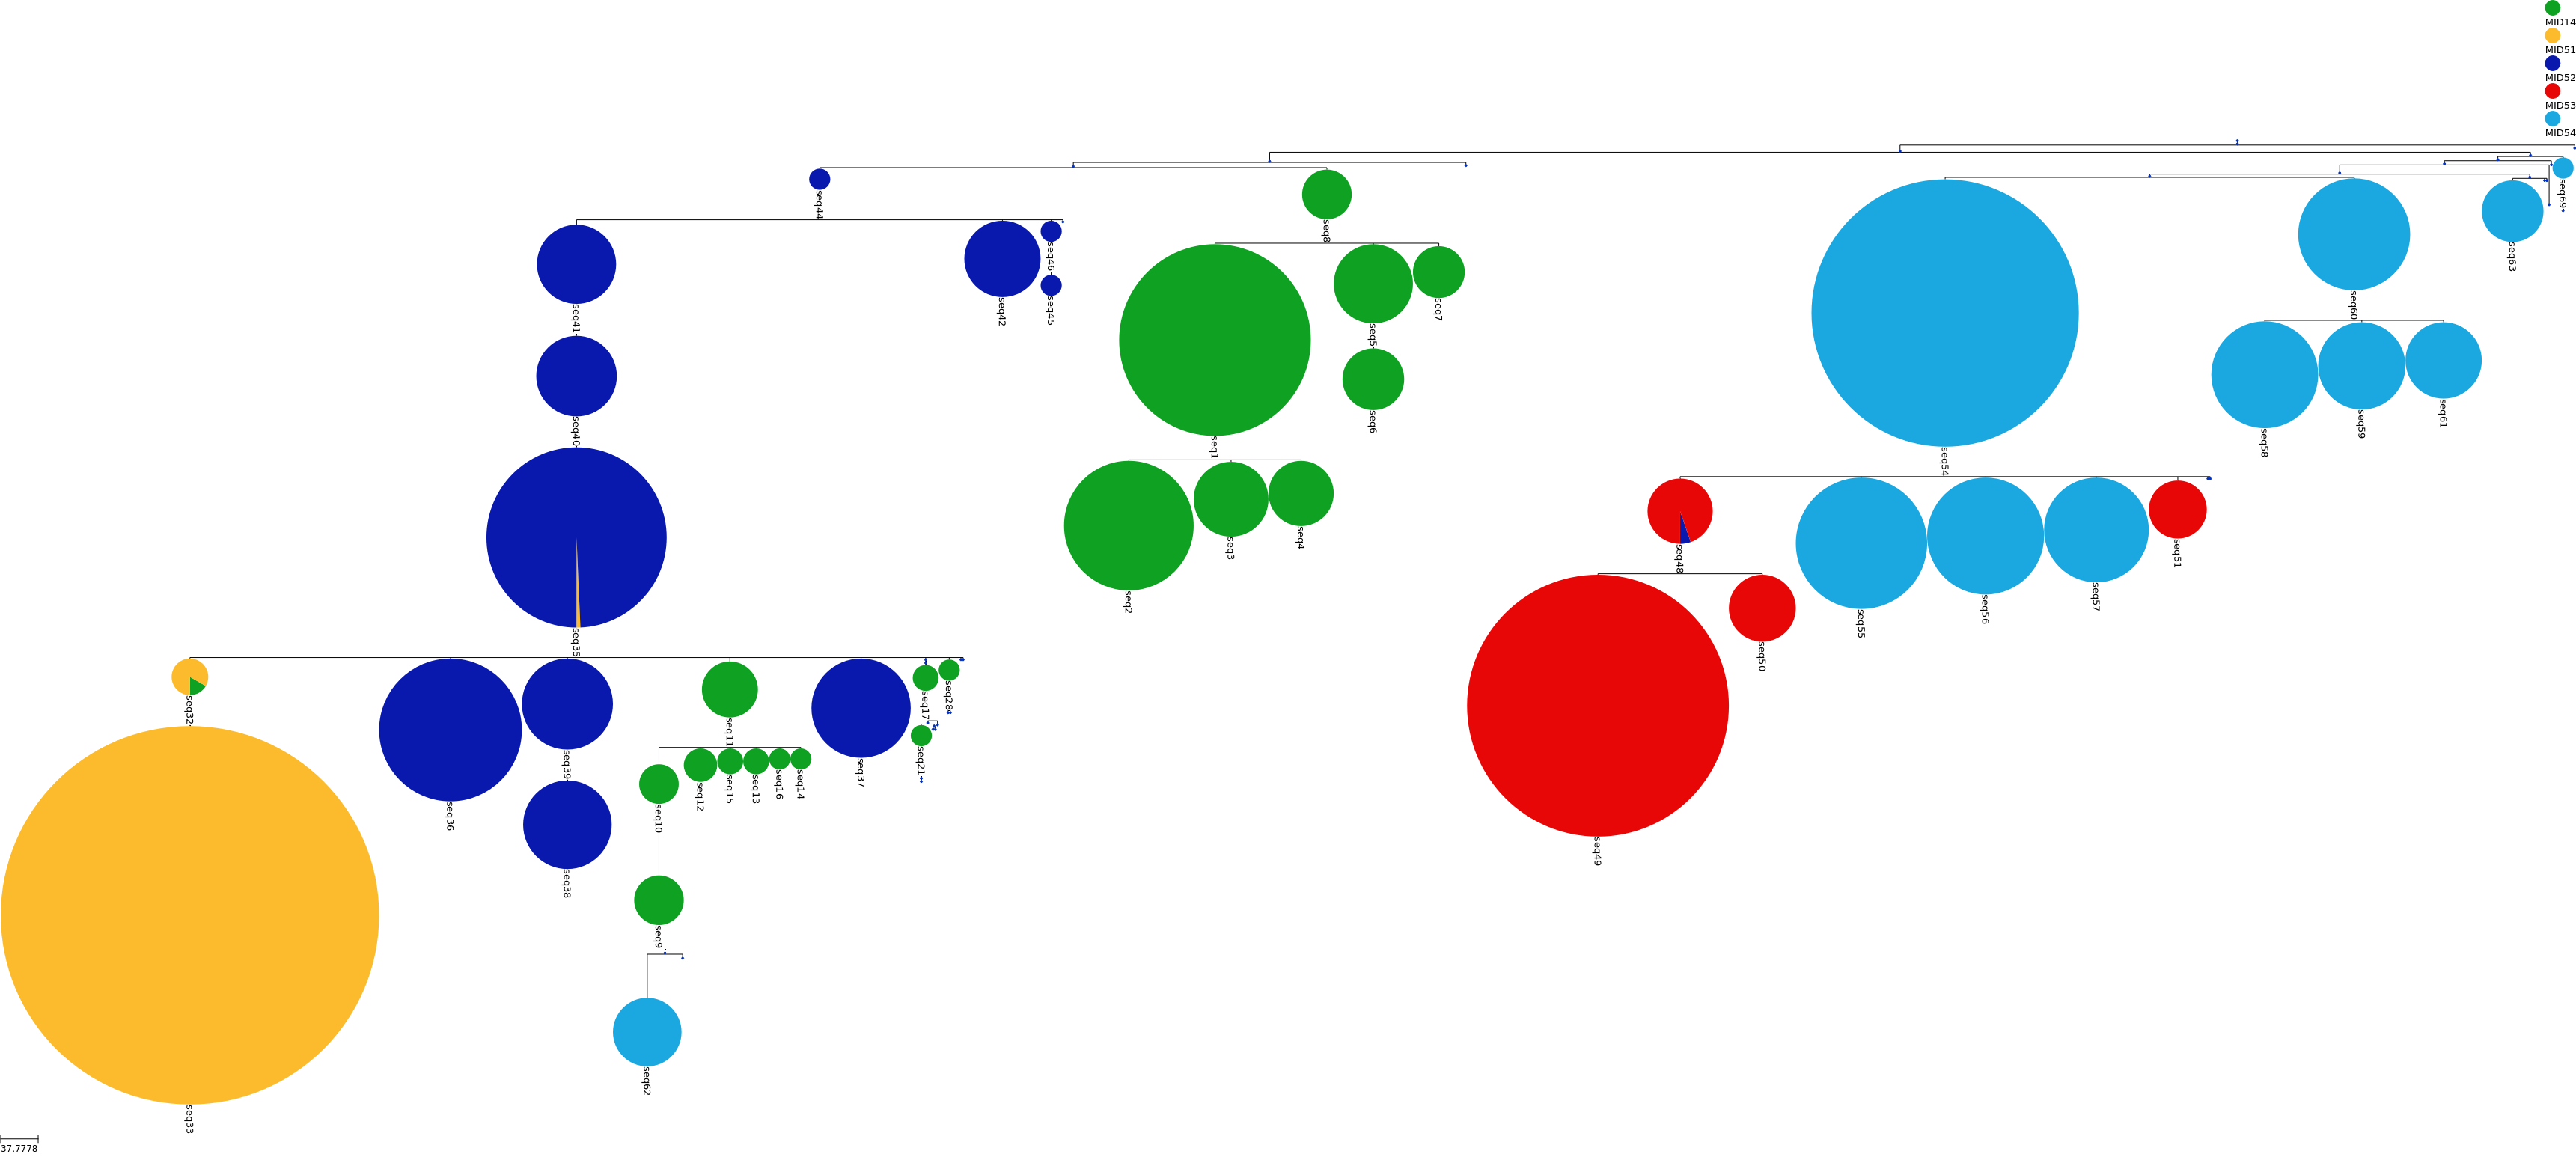

In [5]:
##### analysis example for 1 tree. 
cloneid = "m30_IGHV1-82-01_IGHJ2-01_30_1.aln"

mouseid = cloneid.split("_")[0]
path_to_save_tree_svg = os.path.join(path_to_01_output, mouseid)
os.system(f"mkdir -p {path_to_save_tree_svg}")

treeobj = saveTreeobj[cloneid] 
avai_mids = treeobj.seqdf["MID"].unique()
mid_color_pal = pd.read_csv(color_path, index_col = [0]).to_dict()["hex color"]

ts = treeobj.generate_tree_style(color_path = color_path)
# treeobj.tree.render("%%inline", tree_style=ts) 

for input_mid in avai_mids:
    if input_mid == "GL":
        input_mid_col = "gray"
    else:
        input_mid_col = mid_color_pal[input_mid]
    ts.legend.add_face(CircleFace(10, input_mid_col), column = 0)
    ts.legend.add_face(TextFace(input_mid), column = 0)

idmapdf = treeobj.idmapseqdf.copy()
seqdf = treeobj.seqdf.copy()
seqdf["population"] = seqdf["MID"].apply(lambda x: mid_metadata[mid_metadata["MID"] == x]["population"].values[0])
seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
treeobj.tree.render(f"%%inline", tree_style=ts) 


# Add distance information to all trees

In [6]:
rerun = False
if os.path.isfile(os.path.join(path_to_01_output, "distdf.csv")) == False or rerun == True:
    distdf = pd.DataFrame()
    for cloneid in tqdm(list(saveTreeobj.keys())):
        treeobj = saveTreeobj[cloneid]
        seqdf = treeobj.seqdf.copy()
        idmapdf = treeobj.idmapseqdf.copy()
        seqdf["CDR3nt"] = seqdf["ID"].apply(lambda x: x.split("|")[3].split(":")[1])
        seqdf["CDR3aa"] = seqdf["ID"].apply(lambda x: x.split("|")[2].split(":")[1])
        seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")

        df = pd.DataFrame(data = seqdf.seqid.unique(), columns = ["seqid"])
        df["MID"] = df["seqid"].apply(lambda x: "_".join(seqdf[seqdf["seqid"] == x]["MID"].values))
        df["mouseid"] = cloneid.split("_")[0]
        df["cloneID"] = cloneid
        df["CDR3nt"] = df["seqid"].apply(lambda x: seqdf[seqdf["seqid"] == x]["CDR3nt"].values[0])
        df["CDR3aa"] = df["seqid"].apply(lambda x: seqdf[seqdf["seqid"] == x]["CDR3aa"].values[0])

        df["dist_to_root"] = df["seqid"].apply(lambda x: treeobj.node_depth(node = [item for item in treeobj.nodes if item.name == x][0], topo = False))
        df["topo_dist_to_root"] = df["seqid"].apply(lambda x: treeobj.node_depth(node = [item for item in treeobj.nodes if item.name == x][0], topo = True))

        deepest_node = df[df["dist_to_root"] == df["dist_to_root"].max()].seqid.unique()[0]

        df["dist_to_deepest"] = df["seqid"].apply(lambda x: treeobj.tree.get_distance(x, deepest_node) if x != deepest_node else 0)
        df["topo_dist_to_deepest"] = df["seqid"].apply(lambda x: treeobj.tree.get_distance(x, deepest_node, topology_only= True) if x != deepest_node else 0)

        # function definition
        def get_node_furthest_child(x, topo):
            'Function to get the furthest child node of a given node and the distance to it'
            output = treeobj.tree.search_nodes(name=x)[0].get_farthest_leaf(topology_only= topo)
            return output[0].name, output[1]

        df[['topo_furthest_child_node', 'topo_dist_to_furthest_child_node']] = df['seqid'].apply(
            lambda x: pd.Series(
                get_node_furthest_child(x, True)))
        df[['furthest_child_node', 'dist_to_furthest_child_node']] = df['seqid'].apply(
            lambda x: pd.Series(
                get_node_furthest_child(x, False)))

        change_name = {
            "dist_to_root": "rootness",
            "topo_dist_to_root": "topo_rootness",
            "dist_to_furthest_child_node": "leafness",
            "topo_dist_to_furthest_child_node": "topo_leafness"
        }

        df.columns = [change_name[item] if item in change_name.keys() else item for item in df.columns]
        df["num_node"] = len(treeobj.nodes)
        df["num_leaves"] = len(treeobj.leaves)

        distdf = pd.concat([distdf, df], axis = 0)
    distdf["sample_type"] = distdf["MID"].apply(lambda x: "_".join(mid_metadata[mid_metadata["MID"].isin(x.split("_"))]["population"].values) \
                                                               if "_" in x else mid_metadata[mid_metadata["MID"] == x]["population"].values[0])
    distdf["mix_node"] = distdf["sample_type"].apply(lambda x: "yes" if "_" in x else "no")
    distdf.to_csv(os.path.join(path_to_01_output, f"{PROJECT}_distdf.csv"), index = False)
else:
    print("reading in distance data frame ...")
    distdf = pd.read_csv(os.path.join(path_to_01_output, f"{PROJECT}_distdf.csv"))

reading in distance data frame ...


In [ ]:
import nltk
public_clonedf = pd.read_csv("public_clones.csv")
distdf["V_gene"] = distdf["cloneID"].apply(lambda x: "-".join(x.split("_")[1].split("-")[0:2]))
distdf["J_gene"] = distdf["cloneID"].apply(lambda x: "-".join(x.split("_")[2].split("-")[0:1]))

match_public_clonedf = pd.DataFrame()
for i in range(public_clonedf.shape[0]):
    v_gene = public_clonedf.iloc[i]["V_gene"]
    j_gene = public_clonedf.iloc[i]["J_gene"]
    public_sequence = public_clonedf.iloc[i]["aaseq"]
    tmpdf = distdf[(distdf["V_gene"] == v_gene) & (distdf["J_gene"] == j_gene)]
    tmpdf["public_CDR3nt"] = public_sequence
    match_public_clonedf = pd.concat([match_public_clonedf, tmpdf], axis = 0)

match_public_clonedf["truncated_CDR3aa"] = match_public_clonedf["CDR3aa"].apply(lambda x: x[1:-1])
match_public_clonedf["num_diff_public_clone"] = match_public_clonedf[["truncated_CDR3aa", "public_CDR3nt"]].apply(lambda x: nltk.edit_distance(x[0], x[1]), axis = 1)
match_public_clonedf["dist_to_public_clone"] = match_public_clonedf[["truncated_CDR3aa", "public_CDR3nt"]].apply(lambda x: nltk.edit_distance(x[0], x[1])/min(len(x[0]), len(x[1])), axis = 1)

match_public_clonedf.to_csv(os.path.join(path_to_01_output, "match_public_clonedf.csv"), index = False)

sig_match_public_clonedf = match_public_clonedf[match_public_clonedf["dist_to_public_clone"] <= 0.15]

maindf["match_public_clone"] = maindf["cloneid"].apply(lambda x: "yes" if x in sig_match_public_clonedf["cloneID"].unique() else "no")
for mouseid in maindf.mouseID.unique():
    maindf[maindf["mouseID"] == mouseid].to_csv(os.path.join(path_to_01_output, 'input_circos_public_clones', f"{mouseid}_publicClone.csv"))

In [8]:
# for f in [ 'rootness',
#        'topo_rootness', 'dist_to_deepest', 'topo_dist_to_deepest',
#        'topo_furthest_child_node', 'topo_leafness']:
#     plotdf = distdf[["num_node", "cloneID", "sample_type", f]].copy()
#     plotdf["sample_type"] = plotdf["sample_type"].apply(lambda x: x.split("_")[0])
#     plotdf["mouseID"] = plotdf["cloneID"].apply(lambda x: x.split("_")[0])
#     plotdf = plotdf.explode("sample_type")

#     plotdf["sample_type"] = plotdf["sample_type"].apply(lambda x: "biopsy" if x == "biopsy" else x.replace("Ly6c+", "").replace("Ly6c-", ""))
#     plotdf = plotdf.sort_values(by = ["mouseID", "num_node", "cloneID", "sample_type"], ascending = [True, False, False, True])
#     # plotdf.to_excel(os.path.join(path_to_01_output, f"plotdf_{PROJECT}.xlsx"), index = False)

#     for mouseid in plotdf.mouseID.unique():
#         for sampletype in ["YFP+", "YFP-", "biopsy"]:
#             os.system("mkdir -p {}".format(os.path.join(path_to_01_output, "prism_plots", mouseid)))

#             all_ranked_clones = plotdf[(plotdf["mouseID"] == mouseid) & (plotdf["sample_type"] == sampletype)].cloneID.unique()
#             prism_plotdf = pd.DataFrame()

#             for cloneid in tqdm(all_ranked_clones):
#                 tmpdf =  pd.DataFrame(data = plotdf[plotdf["cloneID"] == cloneid][f].values).T
#                 prism_plotdf = pd.concat([prism_plotdf, tmpdf], axis=0)

#             prism_plotdf.reset_index().drop("index", axis = 1).to_excel(os.path.join(path_to_01_output, "prism_plots", mouseid, f"{sampletype}_{f}.xlsx"), index = False, header = False)

In [9]:
summarydf = distdf.groupby("cloneID")["seqid"].count().reset_index().sort_values(by = "seqid", ascending = False)
summarydf["mouseID"] = summarydf["cloneID"].apply(lambda x: x.split("_")[0])
summarydf["MIds"] = summarydf["cloneID"].apply(lambda x: ",".join(set("_".join(distdf[distdf["cloneID"] == x]["MID"].unique()).split("_"))))
summarydf["num_MID"] = summarydf["cloneID"].apply(lambda x: len(set("_".join(distdf[distdf["cloneID"] == x]["MID"].unique()).split("_"))))
summarydf["rank"] = range(1, summarydf.shape[0] + 1)
summarydf.to_excel(os.path.join(path_to_01_output, "summary_cloneID.xlsx"))

In [10]:
summarydf

,cloneID,seqid,mouseID,MIds,num_MID,rank
3360,m31_IGHV1-15-01_IGHJ2-01_36_1.aln,505,m31,"MID35,MID36,MID38,MID16",4,1
1431,m13_IGHV1-59-01_IGHJ3-01_42_2.aln,381,m13,"MID23,MID25",2,2
279,m11_IGHV1-78-01_IGHJ3-01_24_1.aln,303,m11,"MID12,MID4,MID57,MID58,MID55",5,3
3099,m30_IGHV10-1-01_IGHJ2-01_30_1.aln,219,m30,"MID52,MID53,MID51,MID14,MID54",5,4
2907,m30_IGHV1-64-01_IGHJ2-01_42_1.aln,182,m30,"MID14,MID51,MID53",3,5
...,...,...,...,...,...,...
33,m11_IGHV1-19-01_IGHJ2-01_54_1.aln,2,m11,MID12,1,7614
28,m11_IGHV1-18-01_IGHJ4-01_48_1.aln,2,m11,MID12,1,7615
27,m11_IGHV1-18-01_IGHJ4-01_45_1.aln,2,m11,MID12,1,7616
26,m11_IGHV1-18-01_IGHJ4-01_42_1.aln,2,m11,MID12,1,7617
